# Barcelona test

## Preparations

In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt
import esda
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn import cluster
from libpysal import graph
from splot.esda import lisa_cluster, moran_scatterplot

# Additional library for optimal number of clusters
from kneed import KneeLocator

In [96]:
link = 'https://opendata-ajuntament.barcelona.cat/data/dataset/d8e40c96-9f1f-4fd3-86da-2baa1599616d/resource/edaf6642-a51b-4b2b-a492-fa913d5e8b91/download/2021_atles_renda_bruta_llar.csv'
gross_income = gpd.read_file(link)

children = gpd.read_file('./data/2021_pad_dom_mdbas_edat-0018.csv')

edu = gpd.read_file('./data/2021_pad_mdbas_niv-educa-esta_sexe.csv')

seccio = gpd.read_file('./data/seccio_censal')

### Data Wrangling

In [97]:
# Drop unnecessary columns and rename columns for better understanding
children = children.drop(
    columns=['Data_Referencia',
             'Codi_Barri',
             'Nom_Barri',
             'AEB',
             'geometry',
             'Nom_Districte']
             ).rename(columns={'Codi_Districte': 'district_code',
                               'Seccio_Censal': 'section_code',
                               'Valor': 'households',
                               'DOM_00_18': 'children'}
)
# Convert columns to the correct data type
children['households'] = children['households'].astype(int)
children['children'] = children['children'].astype(int)

# Clean the section code by removing the district code infront
children['district_code_length'] = children['district_code'].str.len()
children['section_code'] = children.apply(
    lambda row: row['section_code'][row['district_code_length']:], axis=1
)
# Drop the temporary column
children = children.drop(columns=['district_code_length'])

# Convert columns to the correct data type
children['section_code'] = children['section_code'].astype(int)
children['district_code'] = children['district_code'].astype(int)

# Calculate average children per household
children['weighted_children'] = children['children'] * children['households']
grouped = children.groupby(['district_code', 'section_code']).agg(
    total_households=('households', 'sum'),
    total_weighted_children=('weighted_children', 'sum')
)
grouped['average_children'] =(
    grouped['total_weighted_children'] / grouped['total_households']
)
# Reset the index and drop temporary columns
children = grouped.reset_index().drop(
    columns=['total_weighted_children',
             'total_households']
)

In [98]:
# Drop unnecessary columns and rename columns for better understanding
gross_income = gross_income.drop(
    columns=['Any', 'Codi_Barri', 'Nom_Barri', 'geometry']
    ).rename(columns={'Import_Renda_Bruta_€': 'gross_income',
                      'Codi_Districte': 'district_code',
                      'Nom_Districte': 'district_name',
                      'Seccio_Censal': 'section_code',}
)
# Convert columns to the correct data type
gross_income['section_code'] = gross_income['section_code'].astype(int)
gross_income['district_code'] = gross_income['district_code'].astype(int)
gross_income['gross_income'] = gross_income['gross_income'].astype(float)

In [99]:
# Drop unnecessary columns and rename columns for better understanding
edu = edu.drop(
    columns=['Data_Referencia',
             'Codi_Barri',
             'Nom_Barri',
             'AEB',
             'geometry',
             'Nom_Districte']
             ).rename(columns={'Codi_Districte': 'district_code',
                               'Seccio_Censal': 'section_code',
                               'Valor': 'people',
                               'NIV_EDUCA_esta': 'education_level',
                               'SEXE': 'gender'}
)

# Clean the section code by removing the district code infront
edu['district_code_length'] = edu['district_code'].str.len()
edu['section_code'] = edu.apply(
    lambda row: row['section_code'][row['district_code_length']:], axis=1
)
# Drop the temporary column
edu = edu.drop(columns=['district_code_length'])

# Convert columns to the correct data type
edu['section_code'] = edu['section_code'].astype(int)
edu['district_code'] = edu['district_code'].astype(int)
edu['people'] = edu['people'].replace('..', 0).astype(float)

# Group by district code, section code, education level and gender and sum the
# people
grouped = edu.groupby([
    'district_code',
    'section_code',
    'education_level',
    'gender']
    )['people'].sum()

# Unstack the grouped data
unstacked = grouped.unstack(level=[2, 3])
unstacked.reset_index(inplace=True)

# Fill the NaN values with 0
unstacked.fillna(0, inplace=True)

# Get rid of the multiindex by joining the columns with an underscore
unstacked.columns = ['_'.join(col) for col in unstacked.columns.values]

# Cleanup after joining the columns and rename the columns for better
# understanding
column_mapping = {
    col: (
        col.replace('_1', '_f')
        .replace('_2', '_m')
        .replace('district_code_', 'district_code')
        .replace('section_code_', 'section_code')
        .replace('1_', 'no_edu_')
        .replace('2_', 'prim_')
        .replace('5_', 'high_')
        .replace('6_', 'no_data_')
        )
        for col in unstacked.columns
}
# Rename the columns
unstacked.rename(columns=column_mapping, inplace=True)

# Merge the third and fourth level of education since Spain has twp different
# levels of high school exams
unstacked['sec_f'] = unstacked['3_f'] + unstacked['4_f']
unstacked['sec_m'] = unstacked['3_m'] + unstacked['4_m']
# Drop the third and fourth level of education
unstacked = unstacked.drop(columns=['3_f', '4_f', '3_m', '4_m'])

# Reorder the columns for more logical order
columns_to_move = ['sec_f', 'sec_m']
new_position = 7

original_columns = unstacked.columns.to_list()

for column in columns_to_move:
    original_columns.remove(column)

for column in columns_to_move:
    original_columns.insert(new_position -1, column)
    new_position += 1

edu = unstacked[original_columns]

In [100]:
# Drop unnecessary columns and rename columns for better understanding
seccio = seccio[['DISTRICTE', 'SEC_CENS', 'geometry']]
seccio = seccio.rename(columns={
    'DISTRICTE': 'district_code',
    'SEC_CENS': 'section_code'}
)
# Convert columns to the correct data type
seccio['district_code'] = seccio['district_code'].astype(int)
seccio['section_code'] = seccio['section_code'].astype(int)

#### Merging

In [101]:
# Merge the dataframes into geopandas dataframe
for df in [children, gross_income, edu]:
    seccio = seccio.merge(df, on=['district_code', 'section_code'])

#### Relative Data

In [102]:
# Get the columns that are related to the education
edu_column = [
    col for col in seccio.columns if col.endswith('_f') or col.endswith('_m')
]
# Calculate the total population by gender aged 16+ 
seccio['pop_f'] = seccio[
    seccio.columns[seccio.columns.str.endswith('_f')]].sum(axis=1)
seccio['pop_m'] = seccio[
    seccio.columns[seccio.columns.str.endswith('_m')]].sum(axis=1)

# Calculate the rate of each education level
for column in edu_column:
    if column.endswith('_f'):
        seccio[column + '_rate'] = seccio[column] / seccio['pop_f'] * 100
    else:
        seccio[column + '_rate'] = seccio[column] / seccio['pop_m'] * 100

seccio.head()

,district_code,section_code,geometry,average_children,district_name,gross_income,no_edu_f,no_edu_m,prim_f,prim_m,...,no_edu_f_rate,no_edu_m_rate,prim_f_rate,prim_m_rate,sec_f_rate,sec_m_rate,high_f_rate,high_m_rate,no_data_f_rate,no_data_m_rate
0,1,5,"POLYGON ((430905.031 4581350.072, 430938.474 4...",1.363542,Ciutat Vella,27950.0,29.0,10.0,237.0,318.0,...,2.917505,0.873362,23.843058,27.772926,40.140845,45.327511,31.388330,23.842795,1.710262,2.183406
1,1,6,"POLYGON ((430874.963 4581396.929, 430870.976 4...",1.318108,Ciutat Vella,33086.0,10.0,6.0,128.0,187.0,...,1.602564,0.722022,20.512821,22.503008,43.108974,46.209386,33.814103,29.362214,0.961538,1.203369
2,1,7,"POLYGON ((430614.207 4581309.336, 430622.668 4...",1.419771,Ciutat Vella,32945.0,10.0,0.0,148.0,311.0,...,1.468429,0.000000,21.732746,29.619048,43.465492,47.428571,32.305433,22.000000,1.027900,0.952381
3,1,8,"POLYGON ((430564.164 4581104.412, 430550.048 4...",1.509542,Ciutat Vella,26200.0,21.0,10.0,360.0,686.0,...,1.860053,0.562746,31.886625,38.604389,44.906997,44.738323,19.574845,14.181204,1.771479,1.913337
4,1,9,"POLYGON ((430275.270 4581082.530, 430331.870 4...",1.433850,Ciutat Vella,30306.0,13.0,6.0,224.0,298.0,...,1.492537,0.579151,25.717566,28.764479,43.857635,44.594595,27.669346,25.096525,1.262916,0.965251


## Exploration

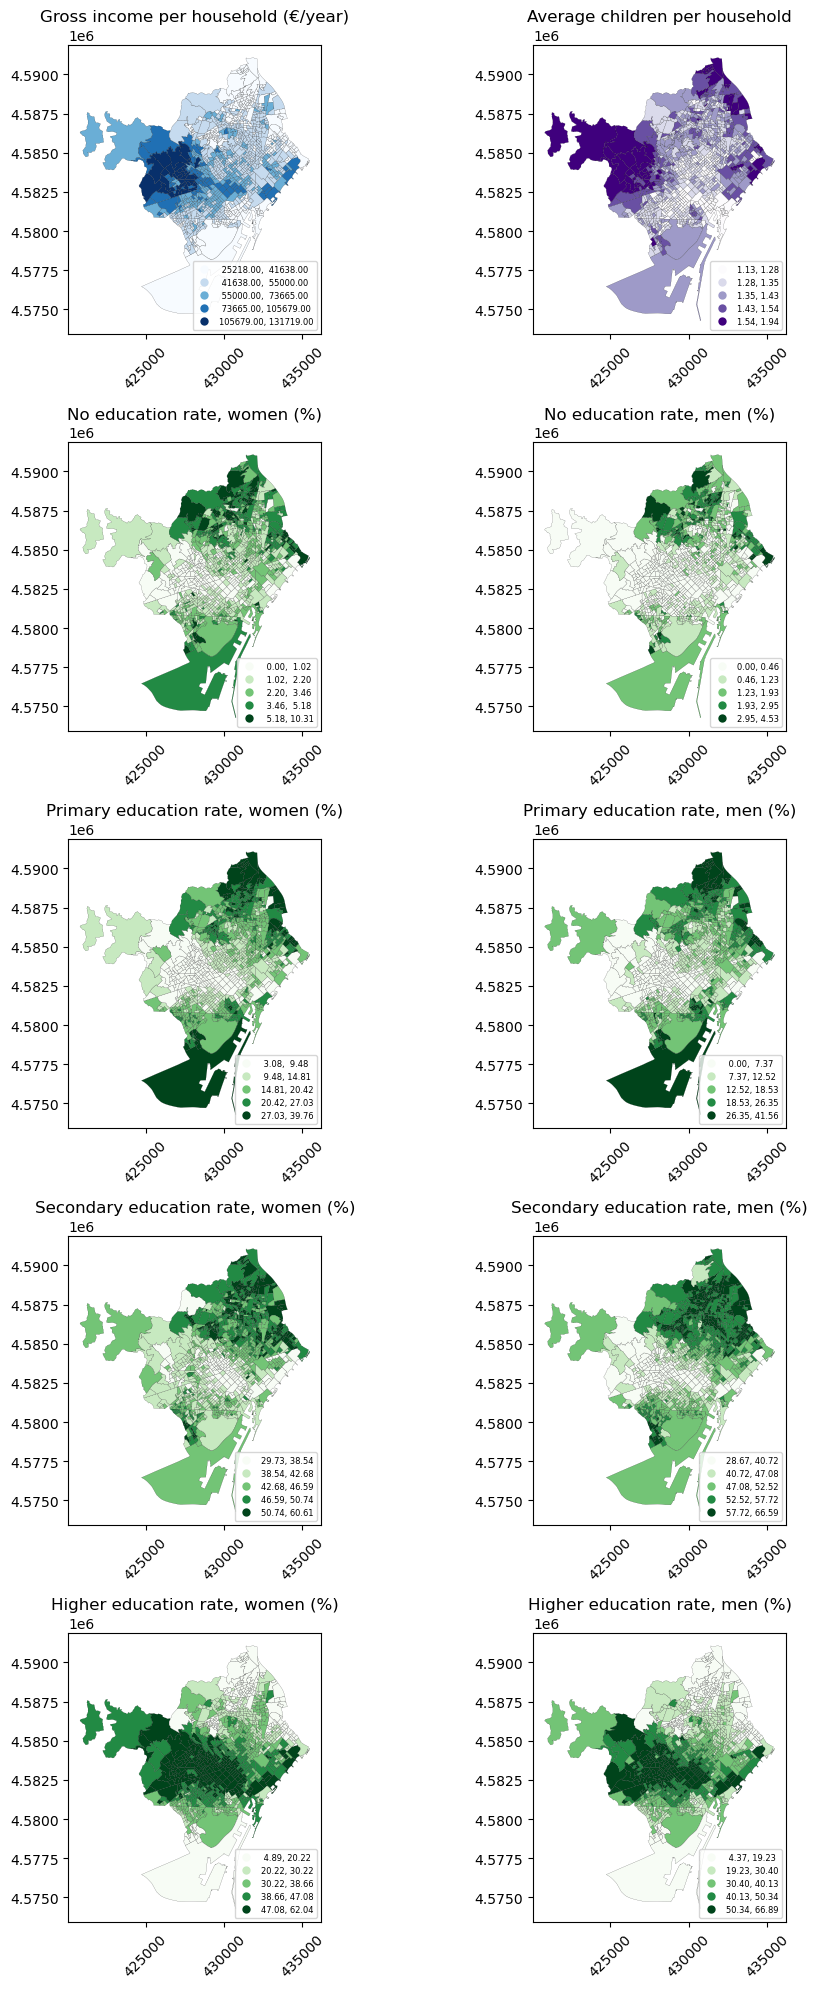

In [103]:
# Plot the data for visual exploration
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

seccio.plot(
    column='gross_income', ax=ax[0, 0],
    legend=True, cmap='Blues',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='average_children', ax=ax[0, 1],
    legend=True, cmap='Purples',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='no_edu_f_rate', ax=ax[1, 0],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='no_edu_m_rate', ax=ax[1, 1],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='prim_f_rate', ax=ax[2, 0],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='prim_m_rate', ax=ax[2, 1],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='sec_f_rate', ax=ax[3, 0],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6, "loc":
        'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='sec_m_rate', ax=ax[3, 1],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={"fontsize": 6,
                 "loc": 'lower right',
                 "markerscale": 0.6}
)
seccio.plot(
    column='high_f_rate', ax=ax[4, 0],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={"fontsize": 6,
                 "loc": 'lower right',
                 "markerscale": 0.6}
)
seccio.plot(
    column='high_m_rate', ax=ax[4, 1],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={"fontsize": 6,
                 "loc": 'lower right',
                 "markerscale": 0.6}
)
# Set the titles
ax[0, 0].set_title('Gross income per household (€/year)')
ax[0, 1].set_title('Average children per household')
ax[1, 0].set_title('No education rate, women (%)')
ax[1, 1].set_title('No education rate, men (%)')
ax[2, 0].set_title('Primary education rate, women (%)')
ax[2, 1].set_title('Primary education rate, men (%)')
ax[3, 0].set_title('Secondary education rate, women (%)')
ax[3, 1].set_title('Secondary education rate, men (%)')
ax[4, 0].set_title('Higher education rate, women (%)')
ax[4, 1].set_title('Higher education rate, men (%)')
# Set the x-axis label rotation for better readability
ax[0, 0].tick_params(axis='x', rotation=45)
ax[0, 1].tick_params(axis='x', rotation=45)
ax[1, 0].tick_params(axis='x', rotation=45)
ax[1, 1].tick_params(axis='x', rotation=45)
ax[2, 0].tick_params(axis='x', rotation=45)
ax[2, 1].tick_params(axis='x', rotation=45)
ax[3, 0].tick_params(axis='x', rotation=45)
ax[3, 1].tick_params(axis='x', rotation=45)
ax[4, 0].tick_params(axis='x', rotation=45)
ax[4, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

### Global spatial autocorrelation

In [104]:
# Build the queen contiguity weights matrix and row standardize it
contiguity = graph.Graph.build_contiguity(seccio, rook=False)
contiguity_r = contiguity.transform("r")

In [105]:
# Calculate Moran's I and its p-value for each variable and print the results
mi = esda.Moran(seccio['gross_income'], contiguity_r.to_W())

summary = f"""\
Moran's I and p-value
=====================
Gross income:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

mi = esda.Moran(seccio['average_children'], contiguity_r.to_W())

summary += f"""\
Children per household:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""
mi = esda.Moran(seccio['high_f_rate'], contiguity_r.to_W())

summary += f"""\
Higher education, women:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

mi = esda.Moran(seccio['high_m_rate'], contiguity_r.to_W())

summary += f"""\
Higher education, men:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

mi = esda.Moran(seccio['prim_f_rate'], contiguity_r.to_W())

summary += f"""\
Primary education, women:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

mi = esda.Moran(seccio['prim_m_rate'], contiguity_r.to_W())

summary += f"""\
Primary education, men:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

print(summary)

Moran's I and p-value
Gross income:
    statistic: 0.833
    p-value: 0.001
Children per household:
    statistic: 0.635
    p-value: 0.001
Higher education, women:
    statistic: 0.866
    p-value: 0.001
Higher education, men:
    statistic: 0.886
    p-value: 0.001
Primary education, women:
    statistic: 0.804
    p-value: 0.001
Primary education, men:
    statistic: 0.8
    p-value: 0.001



### LISA

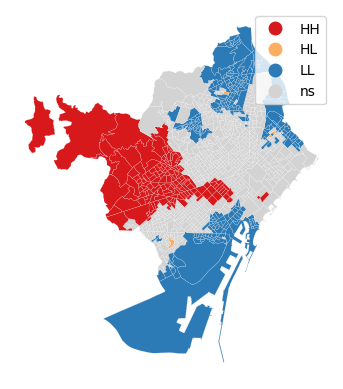

In [106]:
# Plot the LISA cluster map for the gross income
lisa = esda.Moran_Local(seccio['gross_income'], contiguity_r.to_W())
_ = lisa_cluster(lisa, seccio)

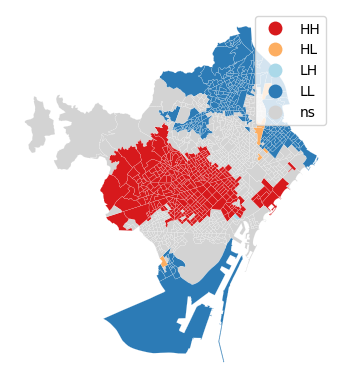

In [107]:
# Plot the LISA cluster map for the higher education of women
lisa = esda.Moran_Local(seccio['high_f_rate'], contiguity_r.to_W())
_ = lisa_cluster(lisa, seccio)

## Clustering

### Preparation

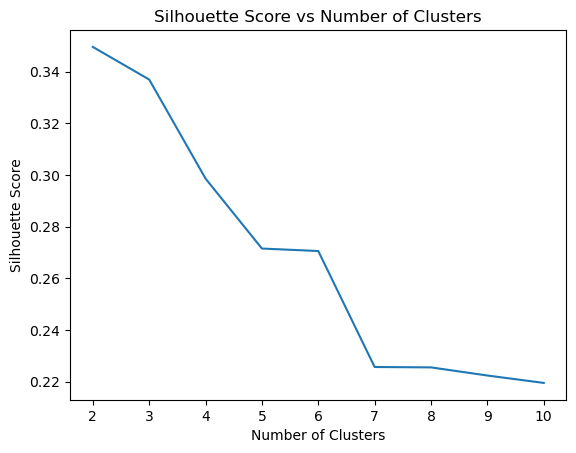

In [108]:
# Prepare the variables for the clustering
subranks = [
    'average_children', 'gross_income',
    'high_f_rate', 'sec_f_rate', 'prim_f_rate', 'no_edu_f_rate',
    'high_m_rate', 'sec_m_rate', 'prim_m_rate', 'no_edu_m_rate'
    ]
# Scale the data using RobustScaler to handle outliers
scaler = RobustScaler()
data_scaled = scaler.fit_transform(seccio[subranks])

# Calculate the silhouette score for different number of clusters
scores = []
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Plot the silhouette score for different number of clusters
plt.plot(range(2, 11), scores)
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [109]:
K = [i for i in range(2, 11)]

# Find the optimal number of clusters using the elbow method
# 'K' is the number of clusters and 'scores' is the silhouette score
knee_locator = KneeLocator(K, scores, curve='convex', direction='decreasing')

optimal_clusters = knee_locator.knee

# Print the optimal number of clusters
print(f'The optimal number of clusters is {optimal_clusters}')

The optimal number of clusters is 7


#### KMeans

In [110]:
# Perform k-means clustering with the optimal number of clusters
kmeans = cluster.KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(data_scaled)
# Add the cluster labels to the dataframe
seccio['kmeans'] = kmeans.labels_

#### Spatially-lagged cluster

In [114]:
# Create new columns for the spatially lagged values of the variables and define
# the variables for the spatially lagged clustering
for column in subranks:
    seccio[column + "_lag"] = contiguity_r.lag(seccio[column])

subranks_lag = [column + "_lag" for column in subranks]
subranks_spatial = subranks + subranks_lag
# Scale the data using RobustScaler to handle outliers
data_scaled_spatial = scaler.fit_transform(seccio[subranks_spatial])

kmeans_lag = cluster.KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_lag.fit(data_scaled_spatial)
# Add the cluster labels to the dataframe
seccio['kmeans_lag'] = kmeans_lag.labels_

#### Regionalisation

In [112]:
# Perform Agglomerative Clustering with the optimal number of clusters
agg = cluster.AgglomerativeClustering(
    n_clusters=optimal_clusters, connectivity=queen.sparse
)

agg.fit(data_scaled)
# Add the cluster labels to the dataframe
seccio['agg'] = agg.labels_

### Visualisation

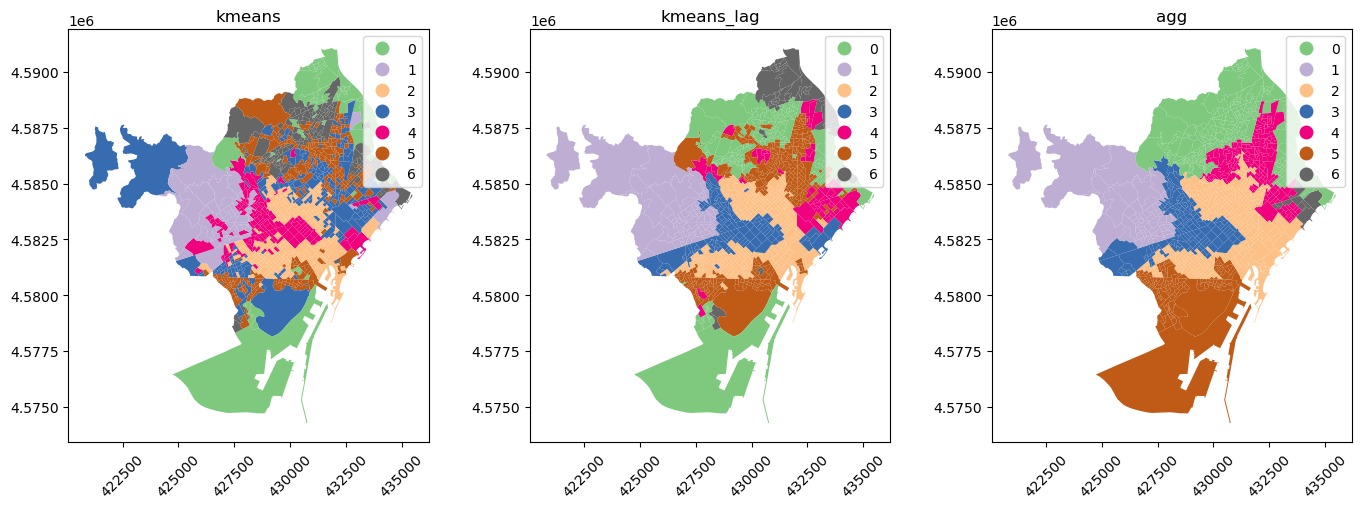

In [113]:
# Plot the different clustering methods on the map
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

seccio.plot(
    column='kmeans',
    ax=ax[0],
    legend=True,
    categorical=True,
    cmap='Accent'
)
seccio.plot(
    column='kmeans_lag',
    ax=ax[1],
    legend=True,
    categorical=True,
    cmap='Accent'
)
seccio.plot(
    column='agg',
    ax=ax[2],
    legend=True,
    categorical=True,
    cmap='Accent'
)
# Set the titles
ax[0].set_title('kmeans')
ax[1].set_title('kmeans_lag')
ax[2].set_title('agg')
# Set the x-axis label rotation for better readability
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
